In [1]:
import time

In [2]:
#%%timeit -n 1 -r 1
start = time.perf_counter()

import torch

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

Elapsed time: 1.072771 seconds


In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Device Info

In [4]:
torch.__version__

'2.4.1'

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.get_device_name()

'NVIDIA L40S'

In [7]:
torch.cuda.list_gpu_processes()

'GPU:0\nno processes are running'

In [8]:
torch.cuda.device_count()

1

In [9]:
# See https://github.com/seafoodfry/ml-workspace/blob/main/gpu-sandbox/our-cuda-by-example/03-cudaDeviceProp.cu
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA L40S', major=8, minor=9, total_memory=45372MB, multi_processor_count=142)

In [10]:
# See https://arnon.dk/matching-sm-architectures-arch-and-gencode-for-various-nvidia-cards/
torch.cuda.get_arch_list()

['sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']

In [11]:
# See
# https://pytorch.org/docs/stable/notes/cuda.html#optimizing-memory-usage-with-pytorch-cuda-alloc-conf
# and
# https://developer.nvidia.com/blog/using-cuda-stream-ordered-memory-allocator-part-1/
torch.cuda.get_allocator_backend()

'native'

In [12]:
# See https://pytorch.org/docs/stable/notes/mps.html
torch.backends.mps.is_available()

False

In [13]:
torch.backends.cuda.is_built()

True

In [14]:
torch.backends.cpu.get_cpu_capability()

'AVX2'

In [15]:
torch.tensor([1])

tensor([1])

In [16]:
torch.tensor([1, 2, 3])

tensor([1, 2, 3])

In [17]:
torch.tensor([
    [1, 2, 3],
    [4, 5, 6],
])

tensor([[1, 2, 3],
        [4, 5, 6]])

In [18]:
# 3D.
torch.tensor([
    [
        [1, 2, 3],
        [4, 5, 6],
    ],
    [
        [7, 8, 9],
        [10, 11, 12],
    ]
])

tensor([[[ 1,  2,  3],
         [ 4,  5,  6]],

        [[ 7,  8,  9],
         [10, 11, 12]]])

In [19]:
torch.tensor([1]).dtype

torch.int64

In [20]:
torch.tensor([1]).to(torch.float32).dtype

torch.float32

In [21]:
torch.tensor([1.0]).dtype

torch.float32

# Forward pass (prediciton step) of a simple logistic regression classifier

In [22]:
import torch.nn.functional as F

In [23]:
# True label.
y = torch.tensor([1.0])

# Input feature.
x1 = torch.tensor([1.1])
w1 = torch.tensor([2.2])
b = torch.tensor([0.0])

z = x1 * w1 + b

activation = torch.sigmoid(z)

loss = F.binary_cross_entropy(activation, y)
loss

tensor(0.0852)

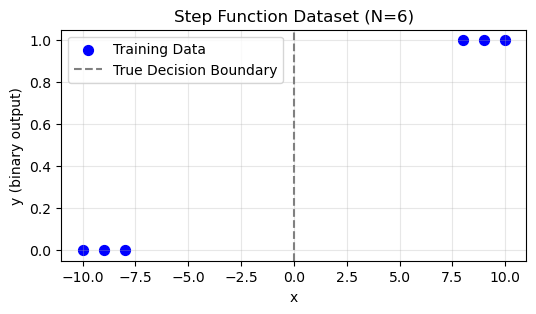

In [24]:
# Create a clear step-function dataset.
x = torch.tensor([[-10.0], [-9.0], [-8.0], [8.0], [9.0], [10.0]], dtype=torch.float32)
y = torch.tensor([[0.0], [0.0], [0.0], [1.0], [1.0], [1.0]], dtype=torch.float32)

# Visualize the dataset
plt.figure(figsize=(6, 3))
plt.scatter(x, y, c='blue', s=50, label='Training Data')
plt.axvline(x=0.0, color='gray', linestyle='--', label='True Decision Boundary')
plt.grid(True, alpha=0.3)
plt.title('Step Function Dataset (N=6)')
plt.xlabel('x')
plt.ylabel('y (binary output)')
plt.legend()
plt.show()

In [25]:
# Model parameters
w = torch.tensor([[0.0]], requires_grad=True)
b = torch.tensor([[0.0]], requires_grad=True)

def net_input(x, w, b):
    return x @ w + b

# Hyperparameters.
learning_rate = 0.1
num_epochs = 100

# Training loop.
losses = []
accuracies = []
print("Training Progress:")
for epoch in tqdm(range(num_epochs)):
    # Forward pass.
    z = net_input(x, w, b)
    # Compute the activation / predicitons.
    predictions = torch.sigmoid(z)
    
    # Compute loss.
    loss = F.binary_cross_entropy(predictions, y)
    
    # Compute accuracy.
    predicted_labels = (predictions >= 0.5).float()
    accuracy = (predicted_labels == y).float().mean()
    
    # Backward pass.
    # PyTorch's way of implementing backpropagation. Tt calculates the gradient of the loss
    # with respect to all parameters that have requires_grad=True.
    loss.backward()
    
    # Update parameters.
    # Temporarily disable gradient tracking.
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad
        w.grad.zero_()
        b.grad.zero_()

    losses.append( loss.item() )
    accuracies.append( accuracy.item() )
    # Print progress every 20 epochs.
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}: Loss = {loss.item():.4f}, Accuracy = {accuracy.item():.2f}')

print("\nFinal Parameters:")
print(f"Weight (w): {w.item():.4f}")
print(f"Bias (b): {b.item():.4f}")

Training Progress:


100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5243.60it/s]

Epoch 20: Loss = 0.0052, Accuracy = 1.00
Epoch 40: Loss = 0.0029, Accuracy = 1.00
Epoch 60: Loss = 0.0020, Accuracy = 1.00
Epoch 80: Loss = 0.0016, Accuracy = 1.00
Epoch 100: Loss = 0.0013, Accuracy = 1.00

Final Parameters:
Weight (w): 0.7619
Bias (b): -0.0000


In [26]:
def custom_scale(x, early=10, late=90):
    """Create a custom scale that compresses the middle section."""
    x = np.array(x)
    
    # Create scaling factors.
    scale_early = 1.0  # Normal scale for early epochs
    scale_middle = 0.1  # Compressed scale for middle epochs
    scale_late = 1.0   # Normal scale for late epochs
    
    result = np.zeros_like(x, dtype=float)
    
    # Apply different scales to different regions.
    mask_early = x < early
    mask_middle = (x >= early) & (x < late)
    mask_late = x >= late
    
    # Early region: normal scale.
    result[mask_early] = x[mask_early]
    
    # Middle region: compressed.
    middle_width = (late - early) * scale_middle
    result[mask_middle] = ( early + (x[mask_middle] - early) * scale_middle )
    
    # Late region: normal scale but shifted due to compression.
    result[mask_late] = ( early + middle_width + (x[mask_late] - late) )
    
    return result

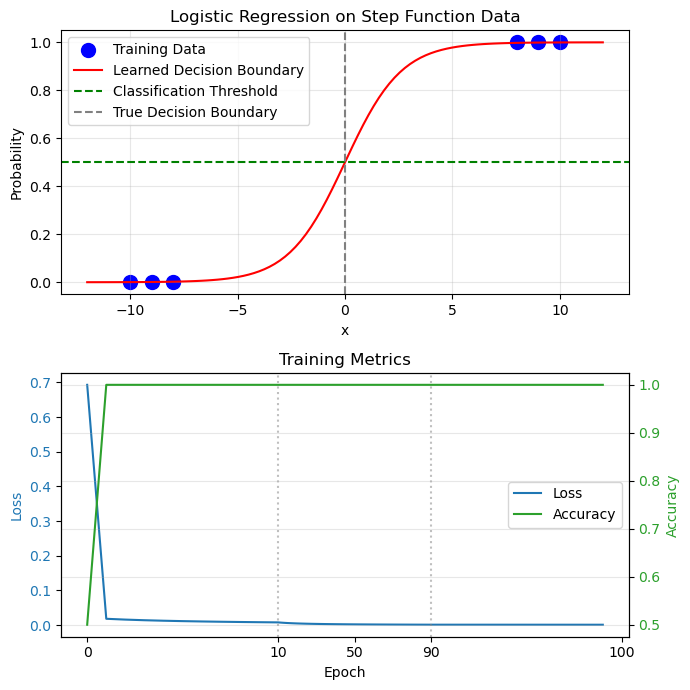

In [27]:
plt.figure(figsize=(7, 7))

#############################
# Plot 1: Decision Boundary #
#############################
plt.subplot(2, 1, 1)
# Plot training data.
plt.scatter(x, y, c='blue', s=100, label='Training Data')

# Plot decision boundary.
x_plot = torch.linspace(-12, 12, 100).reshape(-1, 1)
with torch.no_grad():
    z_plot = net_input(x_plot, w, b)
    y_plot = torch.sigmoid(z_plot)

plt.plot(x_plot, y_plot, 'r-', label='Learned Decision Boundary')
plt.axhline(y=0.5, color='g', linestyle='--', label='Classification Threshold')
plt.axvline(x=0.0, color='gray', linestyle='--', label='True Decision Boundary')

plt.grid(True, alpha=0.3)
plt.title('Logistic Regression on Step Function Data')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()

#################################
# Second row: Loss and Accuracy #
#################################
plt.subplot(2, 1, 2)

epochs = np.arange(len(losses))
epochs_scaled = custom_scale(epochs)

# Plot loss on primary y-axis.
color_loss = 'tab:blue'
ax1 = plt.gca() # get current axis.
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color_loss)
ln1 = ax1.plot(epochs_scaled, losses, color=color_loss, label='Loss')
ax1.tick_params(axis='y', labelcolor=color_loss)

# Plot accuracy on secondary y-axis.
color_acc = 'tab:green'
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color=color_acc)
ln2 = ax2.plot(epochs_scaled, accuracies, color=color_acc, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color_acc)

# Set custom ticks to show actual epoch numbers.
tick_locations = custom_scale([0, 10, 50, 90, 100])
ax1.set_xticks(tick_locations)
ax1.set_xticklabels(['0', '10', '50', '90', '100'])

# Add markers to show scale change.
for _x in [10, 90]:
    scaled_x = custom_scale([_x])[0]
    ax1.axvline(x=scaled_x, color='gray', linestyle=':', alpha=0.5)

# Add legend.
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')

plt.title('Training Metrics')
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

In [28]:
# Print classification results
with torch.no_grad():
    z_test = x @ w + b
    probs = torch.sigmoid(z_test)
    predictions = (probs >= 0.5).float()
    
print("\nClassification Results:")
print("----------------------")
for i in range(len(x)):
    print(f"x = {x[i][0]:.1f}: probability = {probs[i][0]:.4f}, prediction = {predictions[i][0]:.0f}, true_label = {y[i][0]:.0f}")


Classification Results:
----------------------
x = -10.0: probability = 0.0005, prediction = 0, true_label = 0
x = -9.0: probability = 0.0011, prediction = 0, true_label = 0
x = -8.0: probability = 0.0022, prediction = 0, true_label = 0
x = 8.0: probability = 0.9978, prediction = 1, true_label = 1
x = 9.0: probability = 0.9989, prediction = 1, true_label = 1
x = 10.0: probability = 0.9995, prediction = 1, true_label = 1
